In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import h5py

from HelperAndMechanics import *

In [18]:
def euclidean_distance_trajectory(x_arr_test_flattened, x_arr_train_flattened):
    '''calculate the euclidean distance between the test and training data. choses shortest eucledean distance
    shape input 
    x_arr_test_flattened: (Dim_x, number_of_comp, 1,len_t_test)
    x_arr_train_flattened: (Dim_x, number_of_comp, number_of_data_points,len_t_train)
    returns an tuple of indices that gives the index of the corresponding training data and time'''
    index_list = []
    print(x_arr_test_flattened.shape)
    for current_index in range(x_arr_test_flattened.shape[3]):

        x_current = x_arr_test_flattened[:,:,0,current_index]
        x_current_broadcasted = x_current.reshape(x_current.shape[0], x_current.shape[1], 1, 1) 
        squared_differences = (x_arr_train_flattened - x_current_broadcasted) ** 2
        sum_squared_differences = np.sum(squared_differences, axis=0)   
        #print(sum_squared_differences.shape)
        sum_squared_differences = np.sum(sum_squared_differences, axis=0)   
        #print(sum_squared_differences.shape)
        euclidean_distances = np.sqrt(np.squeeze(sum_squared_differences))  
        #print(euclidean_distances.shape)

        # Find the overall minimum distance and its index in the time series
        overall_min_distance = np.min(euclidean_distances)              # Minimum Euclidean distance
        overall_min_flat_index = np.argmin(euclidean_distances)   
        index = np.unravel_index(overall_min_flat_index,euclidean_distances.shape)
        index_list.append(index)

    
    return index_list

def shape_data(x_temp,y_train_raw,x_arr_test_raw,i,j,number_of_comp,number_of_points,delta_t):
    '''takes in the raw data and shapes it into the correct format for euclidean_distance_trajectory
    shape input
    x_arr_train_flattened_raw: (Dim_x, 1,1, len_t_train)
    x_arr_test_flattened_raw: (Dim_x, 1,1, len_t_test)'''
    
    
    x_arr_train_raw = np.array([x_temp[:,:,i,j],x_temp[:,:,i,j+1],x_temp[:,:,i+1,j+1],x_temp[:,:,i+1,j]])
    x_arr_train = np.swapaxes(x_arr_train_raw,1,2)
    x_arr_train_flattened_raw = x_arr_train.reshape(x_arr_train.shape[0]*x_arr_train.shape[1], 1 ,1, -1)       
    
    #x_arr_test_raw = np.array([x_temp[t_start_test:t_stop_test,:,i,j],x_temp[t_start_test:t_stop_test,:,i,j+1],x_temp[t_start_test:t_stop_test,:,i+1,j+1],x_temp[t_start_test:t_stop_test,:,i+1,j]])
    x_arr_test = np.swapaxes(x_arr_test_raw,1,2)
    x_arr_test_flattened_raw = x_arr_test.reshape(x_arr_train.shape[0]*x_arr_train.shape[1], 1, 1, -1)          
    x_arr_test_flattened = x_arr_test_flattened_raw

    y_train = y_train_raw[:,i,j].reshape(y_train_raw.shape[0],1)

    for i_y in range(number_of_points):
        for i_x in range(number_of_points):
            i = 5 + i_y * 10
            j = 5 + i_x * 10
            x_arr_train_temp = np.swapaxes(np.array([x_temp[:,:,i,j],x_temp[:,:,i,j+1],x_temp[:,:,i+1,j+1],x_temp[:,:,i+1,j]]),1,2)
            #x_arr_train_temp = np.swapaxes(x_arr_train_temp,1,2)

            x_arr_train_flattened_temp = x_arr_train_temp.reshape(x_arr_train.shape[0]*x_arr_train.shape[1], 1 ,1, -1)    
            x_arr_train_flattened_raw = np.concatenate((x_arr_train_flattened_raw ,x_arr_train_flattened_temp),axis = 2) 
            y_train = np.concatenate((y_train,y_train_raw[:,i,j].reshape(y_train.shape[0],1)),axis = 1)
    #for scalar points
    # for i in range(5,95,int(100/number_of_points)):
    #     for j in range(5,95,int(100/number_of_points)):
    #         x_train_temp = dA[t_start:t_stop,i,j]
    #         x_train_temp = x_train_temp.reshape(1,1,1,len(x_train_temp))
    x_arr_train_flattened = x_arr_train_flattened_raw
    x_arr_test_flattened = x_arr_test_flattened_raw
    

    #concentate different time shifts of the data
    for shift in range(-int(number_of_comp/2),int(number_of_comp/2)+1):
        if shift == 0:
            continue
        else:
            x_arr_train_flattened_shifted = np.roll(x_arr_train_flattened_raw,shift * delta_t, axis=3)
            x_arr_test_flattened_shifted = np.roll(x_arr_test_flattened_raw,shift * delta_t, axis=3)
            #add to X_arr_train_flattened along axis 1
            x_arr_train_flattened = np.concatenate((x_arr_train_flattened,x_arr_train_flattened_shifted),axis=1)
            x_arr_test_flattened = np.concatenate((x_arr_test_flattened,x_arr_test_flattened_shifted),axis=1)

    return x_arr_train_flattened, x_arr_test_flattened,np.swapaxes((y_train),0,1)

In [3]:
N = 9000
# Load from HDF5
with h5py.File('../data/SpringMassModel/MechanicalData/data_eta05l_u.h5', 'r') as f:
    x_temp = f['x_temp'][:]
    x_cm_temp = f['x_cm_temp'][:]
    u = f['u'][:]
    dA = f['dA'][:]
    f.close()


In [19]:
T = u
t_start,t_stop = 0,6000
i,j = 50,50

T_train = T[t_start:t_stop,i,j]

dA_test = dA[t_stop+500:,i,j]
T_test = T[t_stop+500:,i,j]
x_arr_train_raw = np.array([x_temp[t_start:t_stop,:,i,j],x_temp[t_start:t_stop,:,i,j+1],x_temp[t_start:t_stop,:,i+1,j+1],x_temp[t_start:t_stop,:,i+1,j]])
x_arr_test_raw = np.array([x_temp[t_stop+500:,:,i,j],x_temp[t_stop+500:,:,i,j+1],x_temp[t_stop+500:,:,i+1,j+1],x_temp[t_stop+500:,:,i+1,j]])

[1467 2309]


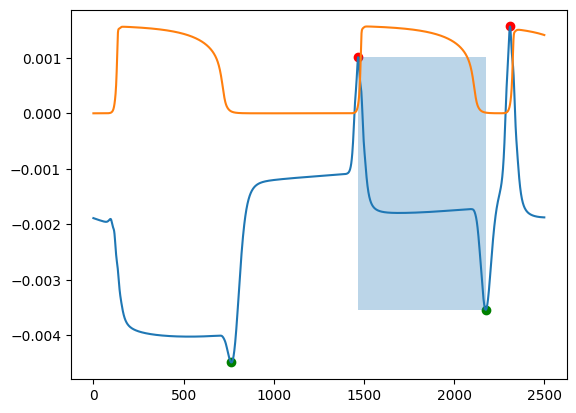

In [20]:
maxima_temp0, _ = find_peaks(dA_test,prominence=.0007)#,height=.001
minima_temp0, _ = find_peaks(-dA_test,prominence=.0007)#,height=.001
print(maxima_temp0)
max_indx, min_indx = index_finder(maxima_temp0, minima_temp0, dA_test,start_indx=0)

plt.plot(dA_test)
plt.scatter(maxima_temp0,dA_test[maxima_temp0],c='r')
plt.scatter(minima_temp0,dA_test[minima_temp0],c='g')
#create a transparent space maxima_temp0[max_indx],minima_temp0[min_indx] on the x axis
plt.fill_between([maxima_temp0[max_indx],minima_temp0[min_indx]],dA_test[minima_temp0[min_indx]],dA_test[maxima_temp0[max_indx]],alpha=.3)
plt.plot(T_test/np.max(T_test)*np.max(dA_test))

t_start_test = t_stop + 500 + maxima_temp0[max_indx] - 200
t_stop_test = t_stop + 500+ minima_temp0[min_indx] + 200

In [22]:
T_test_raw = T[t_start_test:t_stop_test,i,j]
x_arr_test_raw = np.array([x_temp[t_start_test:t_stop_test,:,i,j],x_temp[t_start_test:t_stop_test,:,i,j+1],x_temp[t_start_test:t_stop_test,:,i+1,j+1],x_temp[t_start_test:t_stop_test,:,i+1,j]])


x_arr_train_flattened, x_arr_test_flattened,y_train = shape_data(x_temp[t_start:t_stop,:,:,:],T[t_start:t_stop,:,:],x_arr_test_raw,i,j,3,0,15)
print(x_arr_train_flattened.shape,x_arr_test_flattened.shape)
index_list = euclidean_distance_trajectory(x_arr_test_flattened, x_arr_train_flattened)
#elements = [y_train[row][col] for row, col in index_list]
elements = [y_train[0][row[0]] for row in index_list]

(8, 3, 1, 6000) (8, 3, 1, 1108)
(8, 3, 1, 1108)


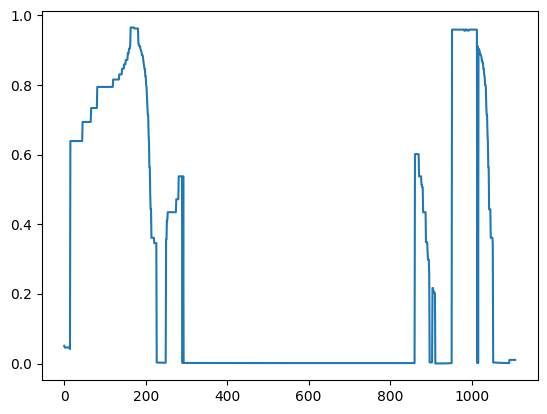

In [23]:
plt.plot(elements)

In [27]:
T_test_raw = T[t_start_test:t_stop_test,i,j]
x_arr_test_raw = np.array([x_temp[t_start_test:t_stop_test,:,i,j],x_temp[t_start_test:t_stop_test,:,i,j+1],x_temp[t_start_test:t_stop_test,:,i+1,j+1],x_temp[t_start_test:t_stop_test,:,i+1,j]])

delta_t = 15
number_of_comp = 3
x_arr_train = np.swapaxes(x_arr_train_raw,1,2)
x_arr_train_flattened_raw = x_arr_train.reshape(8, 1, -1)             
x_arr_train_flattened = x_arr_train_flattened_raw

x_arr_test = np.swapaxes(x_arr_test_raw,1,2)
x_arr_test_flattened_raw = x_arr_test.reshape(8, 1, -1)          
x_arr_test_flattened = x_arr_test_flattened_raw


In [28]:
for shift in range(-int(number_of_comp/2),int(number_of_comp/2)+1):
    if shift == 0:
        continue
    else:
        x_arr_train_flattened_shifted = np.roll(x_arr_train_flattened_raw,shift * delta_t, axis=2)
        x_arr_test_flattened_shifted = np.roll(x_arr_test_flattened_raw,shift * delta_t, axis=2)
        #add to X_arr_train_flattened along axis 1
        x_arr_train_flattened = np.concatenate((x_arr_train_flattened,x_arr_train_flattened_shifted),axis=1)
        x_arr_test_flattened = np.concatenate((x_arr_test_flattened,x_arr_test_flattened_shifted),axis=1)

time_indices = []


#x_arr_train_flattened,x_arr_test_flattened = shape_data(x_arr_train_raw,x_arr_test_raw,0,delta_t,number_of_comp) 

for current_index in range(delta_t*number_of_comp,x_arr_test_flattened.shape[-1]-delta_t*number_of_comp):
    x_current = x_arr_test_flattened[:,:,current_index]
    x_current_broadcasted = x_current.reshape(x_current.shape[0], x_current.shape[1], 1) 
    squared_differences = (x_arr_train_flattened - x_current_broadcasted) ** 2
    #print(squared_differences.shape)
    sum_squared_differences = np.sum(squared_differences, axis=0)   # Shape: (1, len_t)
    #print(sum_squared_differences.shape)
    sum_squared_differences = np.sum(sum_squared_differences, axis=0)   # Shape: (1, len_t)
    #print(sum_squared_differences.shape)
    euclidean_distances = np.sqrt(np.squeeze(sum_squared_differences))  # Shape: (len_t,)#print('shape (len_t,)',euclidean_distances.shape)
    #print(euclidean_distances.shape)
    # Find the overall minimum distance and its index in the time series
    overall_min_distance = np.min(euclidean_distances)              # Minimum Euclidean distance
    overall_min_flat_index = np.argmin(euclidean_distances)              # Time index where minimum occurs
    
    time_indices.append(overall_min_flat_index)
    

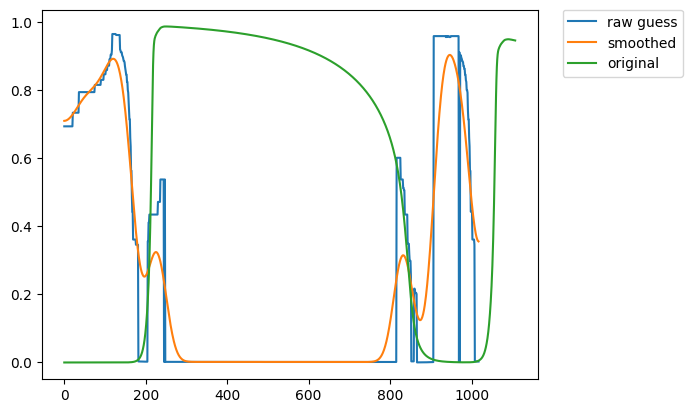

In [29]:
#apply gaussian smoothing to T_train
from scipy.ndimage import gaussian_filter1d

T_train_smoothed = gaussian_filter1d(T_train[time_indices], sigma=20)

plt.plot(T_train[time_indices], label='raw guess')
plt.plot(T_train_smoothed, label='smoothed')
plt.plot(T_test_raw, label='original')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)